In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import re
import json
import collections


from util import get_data
from util import mapping
from util import clean_data
from util import config
from util import plot_clusters
from util import process_data

import sklearn.cluster
import sklearn.neighbors
import scipy
import pydeck as pdk


In [12]:
RTE_IDS = pd.read_feather(config.PROCESSED_DATA_PATH + 'deduped_rte_ids.feather')
trips_unscaled = process_data.get_features_from_rte_files(RTE_IDS.rte_id.values)
# trips_unscaled = pd.read_feather(config.PROCESSED_DATA_PATH + 'trips_unscaled.feather')
trips_unscaled.describe()

0
1000
2000
3000
4000
5000


,rte_id,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent
count,4.871000e+03,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000
mean,3.166562e+07,35.904408,3.970781,-1.167413,12.541906,0.141471,0.090769,0.047210,0.016156,0.005258
std,1.697550e+07,20.284349,1.376976,0.880347,4.727895,0.079782,0.064960,0.046103,0.024209,0.011555
min,1.575248e+06,1.403826,0.000000,-9.636679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.679946e+07,21.310344,3.015837,-1.484022,9.239320,0.082690,0.042526,0.013998,0.000480,0.000000
50%,3.438847e+07,31.796990,3.748798,-0.970051,12.210086,0.131899,0.079627,0.034416,0.007084,0.000207
75%,4.816913e+07,46.229336,4.696955,-0.601602,15.685277,0.191754,0.126949,0.066330,0.021327,0.005267
max,5.651015e+07,122.442250,9.957725,0.330684,24.984074,0.689942,0.554247,0.446546,0.216830,0.128748


In [ ]:
feature_importance_dict = {'dist': 1.,
                      'avg_slope_climbing': 0.2,
                      'avg_slope_descending': 0.01,
                      'max_slope': 0.2,
                      'dist_climbing': 0.3,
                      'dist_downhill': 0.01,
                      'dist_6percent': 0.2,
                      'dist_9percent': 0.2,
                      'dist_12percent': 0.1,
                      'avg_speed': 0.}

In [ ]:
trips_unscaled.describe()

In [11]:
trips_eng.head()

,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent
rte_id,,,,,,,,,
route_34334830,1.415290,2.025529,-1.120306,2.984263,0.000000,0.019115,-4.605170,-4.605170,-4.605170
route_34334875,2.165870,2.456709,-2.406079,3.966738,0.164223,0.161562,-4.605170,-4.605170,-4.605170
route_34334946,2.762965,1.905140,-1.193684,3.434928,0.022188,0.026832,-4.605170,-4.605170,-4.605170
route_34334973,1.905830,7.298974,-0.333762,17.407062,0.609237,0.000000,-1.135636,-1.135636,-1.522213
route_34334993,2.480452,3.546268,-1.055622,5.364467,0.113024,0.093117,-4.605170,-4.605170,-4.605170


In [13]:
trips_eng = process_data.engineer_features(trips_unscaled)

trips_eng.set_index('rte_id', inplace=True)
pop_detour = pd.read_feather(config.PROCESSED_DATA_PATH + 'rte_pop_detour.feather')

trips_all = pd.merge(trips_eng, pop_detour, on='rte_id')

trips_scaled = process_data.scale_dataset(trips_all)
trips_all.describe()

,rte_id,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent,detour_score,popularity
count,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03
mean,3.166562e+07,-4.434510e-16,-6.841399e-16,-2.071383e-16,-2.990377e-17,1.166976e-16,-1.429546e-16,6.710114e-17,4.576735e-16,-3.697856e-16,2.508999e-16,3.500929e-16
std,1.697550e+07,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00
min,1.575248e+06,-5.126979e+00,-2.883993e+00,-9.621358e+00,-2.653019e+00,-1.773386e+00,-1.397458e+00,-1.814207e+00,-1.030798e+00,-6.374766e-01,-4.108109e+00,-1.879065e+00
25%,1.679946e+07,-5.974922e-01,-6.935792e-01,-3.596789e-01,-6.986038e-01,-7.368308e-01,-7.427356e-01,-7.148312e-01,-9.611148e-01,-6.374766e-01,-4.062552e-01,-7.603765e-01
50%,3.438847e+07,7.027952e-02,-1.612270e-01,2.242096e-01,-7.019065e-02,-1.199887e-01,-1.715456e-01,5.831784e-02,-2.354567e-01,-5.917218e-01,1.448026e-01,-7.686304e-03
75%,4.816913e+07,6.948492e-01,5.274233e-01,6.427784e-01,6.649246e-01,6.303170e-01,5.570127e-01,7.383434e-01,6.649823e-01,3.067363e-01,6.200186e-01,6.235850e-01
max,5.651015e+07,2.320590e+00,4.348340e+00,1.701886e+00,2.631921e+00,6.875296e+00,7.135562e+00,2.984624e+00,3.604932e+00,5.231462e+00,2.795985e+00,4.950016e+00


In [ ]:
    feature_sc = pd.read_feather(config.MODEL_PATH + 'feature_importance.feather')
    feature_scaling = dict()
    for i, row in feature_sc.iterrows():
        feature_scaling[row.feature_names] = abs(row.scaling)
    # Other features
    feature_scaling['popularity'] = 0.5
    feature_scaling['detour_score'] = 0.5
    feature_scaling

In [14]:
pts_per_degree = 500
gp, gd = clean_data.make_road_backbone(trips_scaled.rte_id.tolist(), 
    'grid_points_{}'.format(pts_per_degree),
    'rtes_at_grid_{}'.format(pts_per_degree),
     pts_per_degree)
gridpts_at_rte = clean_data.find_gridpts_at_rte(
    gd, 'gridpts_at_rte', pts_per_degree)

Looping through route IDs
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
Total points: 76299


In [3]:
# Rte ids in Minnewaska State Park cluster
RTE_IDS = [32387099, 43436082, 53211196, 40425557, 34291826, 21194883,35145862, 40880294, 18430121, 6017249,
           34762991, 10649846, 18686207, 52060449, 36804903, 12863786, 18594094, 53207371, 37439840, 3666273,
            6650239, 9724306, 53311918, 53000647, 2296298, 16593404, 41435646, 53553673, 10461777, 26380904,
            19012201, 40714860, 10341008, 11563664, 19858072, 37870250, 50404119, 50404128, 53214007, 18535239,
            1772376, 34466669, 34466675, 9907073, 39160726, 50492314, 54999963, 38513605, 3584966, 32252875, 16421847,
            52153335, 36355114, 35226676, 52802621, 5858379, 3699799, 53210219, 32197759, 16868489, 17712286,
           16964783, 4205764, 3640517, 36005065, 37436626, 15963349, 15963352, 31886576, 49710329, 28220665,
           42640650, 26987786, 20102455, 34565443, 5535071, 51903860, 47756689, 52196766, 52905385, 25019850,
            52030998, 6970938, 17239638, 14014044, 10782315, 28382837, 10782326, 18413176, 17172107,
           51941018, 15584930, 50996928, 15584966, 53348061, 54910691, 54986484, 18810627, 16133940, 31102803,
            10364760, 31819615, 34459497, 49493871, 9346933, 55910262, 54155128, 37742462, 16367562, 11513851]

In [4]:
# RTE_IDS = pd.read_feather(config.PROCESSED_DATA_PATH + 'deduped_rte_ids.feather')
locs = []
c = (41.95, -74.2)
d = 0.025
n = 0
for i, rte_id in enumerate(RTE_IDS):#.rte_id.tolist()):
    if not i % 500: print(i)
    a = pd.read_feather(config.CLEAN_TRIPS_PATH + '{}.feather'.format(rte_id))   
    locs += [{'rte_id': rte_id, 'lat': a.lat.values, 'lon': a.lon.values}]
#     n += a.shape[0]
#     if a[(a.lat < c[0] + d) & (c[0] - d < a.lat) & (c[1] - d < a.lon) & (a.lon < c[1] + d)].shape[0]:
#     locs += [{'rte_id': rte_id,
#             'lat': a[(a.lat < c[0] + d) & (c[0] - d < a.lat) & (c[1] - d < a.lon) & (a.lon < c[1] + d)].lat.values, 
#              'lon': a[(a.lat < c[0] + d) & (c[0] - d < a.lat) & (c[1] - d < a.lon) & (a.lon < c[1] + d)].lon.values}]
locs = pd.DataFrame(locs)
locs.head()

0


,rte_id,lat,lon
0,32387099,"[41.728535, 41.728512, 41.728485, 41.728443, 4...","[-74.237328, -74.23738890000001, -74.237411, -..."
1,43436082,"[41.734257, 41.734257, 41.734257, 41.734257, 4...","[-74.244431, -74.244431, -74.244431, -74.24443..."
2,53211196,"[41.7296454, 41.7296422, 41.7296498, 41.729648...","[-74.23467420000001, -74.2346737, -74.23465329..."
3,40425557,"[41.72997, 41.72997470000001, 41.7299842, 41.7...","[-74.2352608, -74.2352507, -74.235232, -74.235..."
4,34291826,"[41.730686, 41.730686, 41.730686, 41.730686, 4...","[-74.235252, -74.235252, -74.235252, -74.23525..."


In [28]:
lats = [lat for i, row in locs.iterrows() for lat in row.lat]
lons = [lon for i, row in locs.iterrows() for lon in row.lon]
rte_id = [row.rte_id for i, row in locs.iterrows() for lon in row.lon]

# locs.set_index('rte_id', inplace=True)
locs.shape
# grid_pts_500.shape

(110, 3)

In [31]:
a = pd.DataFrame({'rte_id': rte_id, 'lat': lats, 'lon': lons})
a.lat.nunique()

115179

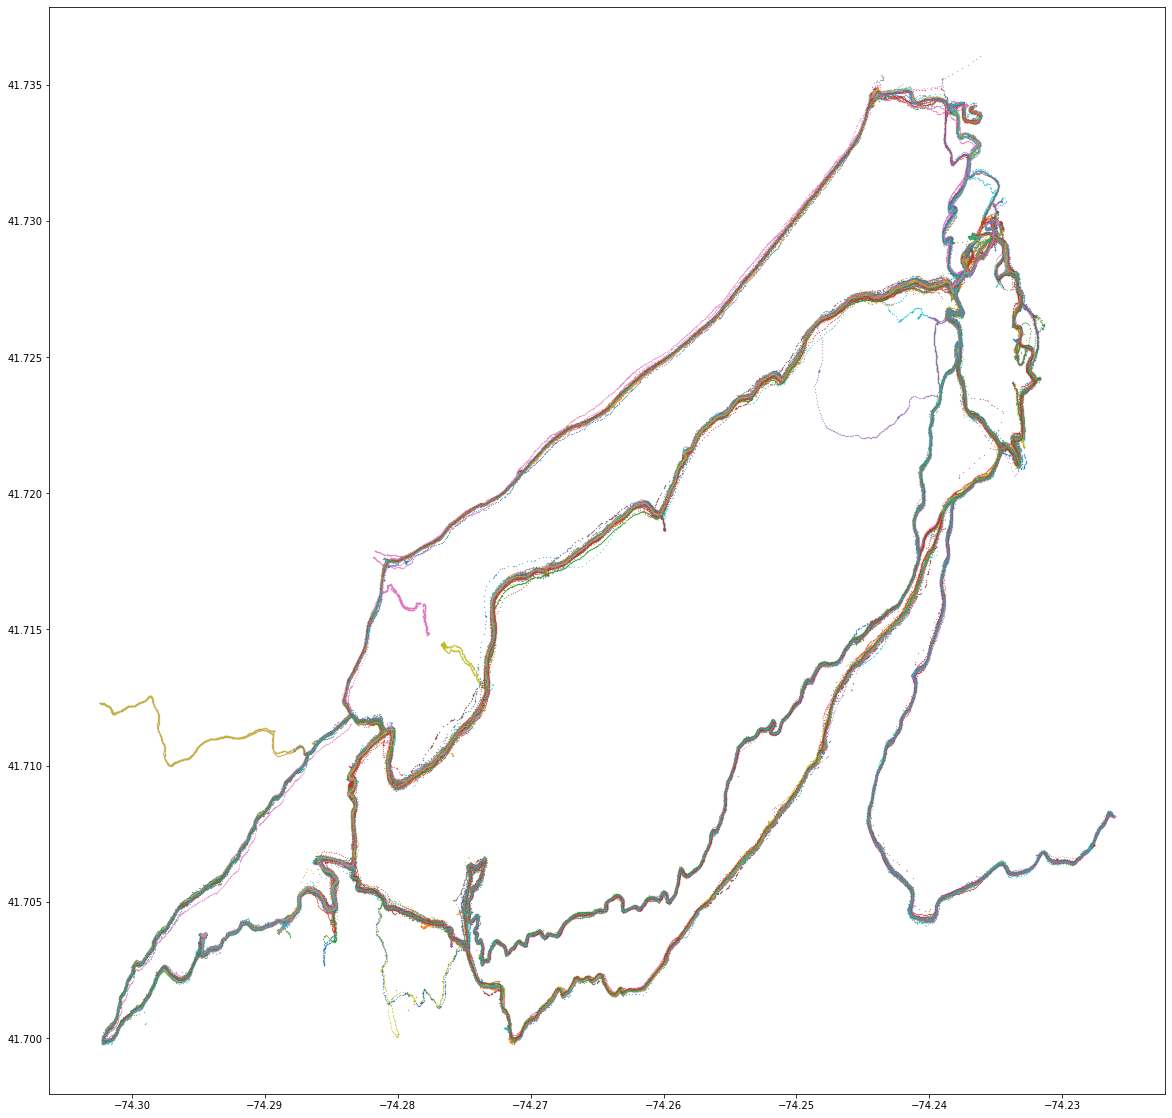

In [30]:
plt.figure(figsize=(20, 20))

for rte_id in locs.index.tolist():
    plt.plot(locs.loc[rte_id].lon, locs.loc[rte_id].lat, '.', markersize=0.5)

In [17]:
grid_pts_500 = gp
grid_pts_500.head()

,grid_id,lat,lon,breadcrumb_count,n_routes
0,1133396,42.293083,-73.988976,351.0,10
1,1134894,42.290040,-73.986093,21.0,6
2,1134895,42.291214,-73.987080,156.0,6
3,1134896,42.292615,-73.987029,95.0,6
4,1136210,41.920661,-73.985056,2453.0,72


In [35]:
grid_pts_25 = pd.read_feather(config.MODEL_PATH + 'grid_points_25.feather')

In [62]:
a = pd.read_feather(config.PROCESSED_DATA_PATH + 'detours.feather')
a = pd.merge(grid_pts_500, a, on='grid_id')
a['ds'] = a.detours_prop.apply(np.mean)
a = a[a.n_routes > 10]

(array([ 391.,  844., 1733., 4347., 6565., 6625., 3093., 1420.,  485.,
          50.]),
 array([4.47599604e-05, 5.74477450e-02, 1.14850730e-01, 1.72253715e-01,
        2.29656700e-01, 2.87059685e-01, 3.44462670e-01, 4.01865656e-01,
        4.59268641e-01, 5.16671626e-01, 5.74074611e-01]),
 <BarContainer object of 10 artists>)

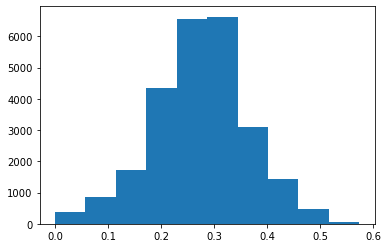

In [63]:
plt.hist(a.ds)

In [20]:
layers

[{"@@type": "ScatterplotLayer", "data": [{"coordinates": [-73.98452439927799, 41.923040748856806]}, {"coordinates": [-73.98437359896772, 41.92524888141936]}, {"coordinates": [-73.98480968418718, 42.22545895837439]}, {"coordinates": [-73.983540419182, 41.921195048329494]}, {"coordinates": [-73.98304376402116, 41.94334146957671]}, {"coordinates": [-73.98280812386781, 41.944524760465136]}, {"coordinates": [-73.9830832997455, 42.22500476475826]}, {"coordinates": [-73.98033656530612, 41.915484937414966]}, {"coordinates": [-73.98112751193766, 41.9190326289742]}, {"coordinates": [-73.98158846623377, 41.94549902285714]}, {"coordinates": [-73.98066779199459, 41.94693075617367]}, {"coordinates": [-73.98099196194505, 42.224449692389]}, {"coordinates": [-73.97887870266534, 41.9127741650543]}, {"coordinates": [-73.97941606587185, 41.94903843010432]}, {"coordinates": [-73.97843232623272, 41.950647974556226]}, {"coordinates": [-73.9789901409978, 42.22451852147506]}, {"coordinates": [-73.9764588159523

In [19]:
layers = []
d=1
c = (41.8, -74.3)
colours = sns.color_palette(['#b68679', '#df8770', '#d4350b', '#a52300', '#7a2008'])
bin_lims = [20, 70, 100, 125, 175, 1000]
# bin_lims = [0.15, 0.275, 0.35, 0.4, 0.45, 1]
for i, b in enumerate(bin_lims[:-1]):
#     gp = a[(b <= a.ds) & (a.ds < bin_lims[i + 1])]
    gp = grid_pts_500[(b <= grid_pts_500.n_routes) & (grid_pts_500.n_routes < bin_lims[i + 1])]
    layers += [pdk.Layer(
        type="ScatterplotLayer",
        data = pd.DataFrame({
            'coordinates': [[lon, lat] for lat, lon in zip(gp.lat, gp.lon)],
        }),
        filled=True,
        stroked=False,
        get_position="coordinates",
        get_radius=150,
        min_pixel_width = 5,
        get_fill_color=[int(x * 255) for x in colours[i]]
    )]
# colours = sns.color_palette(["#7A2008", "#d4350b", "#ff5224",  "#b68679", "#df8770"])
# for i, rte_id in enumerate(locs.index.tolist()):
#     layers += [pdk.Layer(
#         type="ScatterplotLayer",
#         data = pd.DataFrame({
#             'coordinates': [[lon, lat] for lat, lon in zip(locs.loc[rte_id].lat, locs.loc[rte_id].lon)],
#         }),
#         filled=True,
#         stroked=False,
#         get_position="coordinates",
#         get_radius=2,
#         get_fill_color=[int(x * 255) for x in colours[i % 5]]
#     )]
# gp = grid_pts_1000[(grid_pts_1000.lat < c[0] + d) & (c[0] - d < grid_pts_1000.lat) 
#                    & (c[1] - d < grid_pts_1000.lon) & (grid_pts_1000.lon < c[1] + d)]
# gp = grid_pts_25
# layers = [pdk.Layer(
#     type="ScatterplotLayer",
#     data = pd.DataFrame({
#         'coordinates': [[row.lon, row.lat] for i, row in gp.iterrows()]
#     }),
#     filled=True,
#     stroked=False,
#     get_position="coordinates",
#     get_radius=500,
#     min_pixel_width=30,
#     get_fill_color=[int(x * 255) for x in colours[1]]
# )]
r = pdk.Deck(
    map_style="mapbox://styles/mapbox/light-v10",
    initial_view_state=pdk.data_utils.compute_view([
        [c[1] + d, c[0] + d],
        [c[1] + d, c[0] - d],
        [c[1] - d, c[0] + d],
        [c[1] - d, c[0] - d],
    ]),
    layers=layers,
    tooltip={"html": "<b>Ride {name}</b>", "style": {"color": "white"}},
    mapbox_key=os.getenv('MAPBOX_API_KEY')
)
r.to_html('gridpts')

## Features

In [ ]:
RTE_IDS = pd.read_feather(config.PROCESSED_DATA_PATH + 'deduped_rte_ids.feather')

trip_data = []
for i, rte_id in enumerate(rides.index.tolist()):
#     if rte_id == 23586828: continue
    if not i % 200: print(i)
    a = pd.read_feather(config.CLEAN_TRIPS_PATH + '{}.feather'.format(rte_id))
    if a.dist.sum() < 1:
        continue
    if 5 * mapping.dist_lat_lon(a.lat.min(), a.lon.min(), a.lat.max(), a.lon.max()) < a.dist.sum():
        print('{}: whirly!'.format(rte_id))
        continue
        
    max_slope = a.slope.max()
    avg_slope_climbing = a[a.slope > 3].slope.mean()
    avg_slope_descending = a[a.slope < -3].slope.mean()
    dist_climbing = a[a.slope > 3].dist.sum() / a.dist.sum()
    dist_downhill = a[a.slope < -3].dist.sum() / a.dist.sum()
    dist_6percent = a[a.slope > 6].dist.sum() / a.dist.sum()
    dist_9percent = a[a.slope > 9].dist.sum() / a.dist.sum()
    dist_12percent = a[a.slope > 12].dist.sum() / a.dist.sum()
    
    avg_speed = a[a.speed > 2].speed.mean()
    a['dt'] = a.time.diff()
    a.at[0, 'dt'] = 0
    stopped_time = a[a.speed < 2].dt.sum() / a.time.max()
    
    dist = a.dist.sum()
    
    trip_data += [{'rte_id': rte_id, 'dist': dist, 'avg_slope_climbing': avg_slope_climbing, 'avg_slope_descending': avg_slope_descending,
                  'max_slope': max_slope, 'dist_climbing': dist_climbing, 'dist_downhill': dist_downhill,
                  'dist_6percent': dist_6percent, 'dist_9percent': dist_9percent, 'dist_12percent': dist_12percent,
                  }]

        
trips = pd.DataFrame(trip_data)
    

In [ ]:
# mapping.dist_lat_lon(a.lat.min(), a.lon.min(), a.lat.max(), a.lon.max())
rte_id = 25521089
a = pd.read_feather(config.CLEAN_TRIPS_PATH + '{}.feather'.format(rte_id))
# plt.plot(a.lon, a.lat, 'k.')
plt.plot(np.cumsum(a.dist), a.slope)
plt.ylim([-20, 20])

In [ ]:
t2 = trips[(-10 < trips.avg_slope_descending) & (trips.avg_slope_climbing < 10)]
t2 = t2.drop(t2.index[t2.max_slope > 25])
t2 = t2[(2 < t2.avg_speed) & (t2.avg_speed < 30)]
t2.drop('stopped_time', axis=1, inplace=True)
t2.describe()

In [ ]:
print(t2.shape)
plt.hist(t2.avg_slope_climbing)

In [ ]:
# t2.reset_index(drop=True).to_feather(config.PROCESSED_DATA_PATH + 'trips_culled.feather')
t2 = pd.read_feather(config.PROCESSED_DATA_PATH + 'trips_culled.feather')

In [ ]:
t3 = process_data.scale_dataset(t2.set_index('rte_id'), [1] * (len(t2.columns) - 1))
t3.reset_index().to_feather(config.PROCESSED_DATA_PATH + 'trips_culled_scaled.feather')
t3

In [ ]:
sd = pd.read_feather(config.MODEL_PATH + 'feature_scaling.feather')
sd = sd.set_index('index')
sd

## Weirder features!

In [38]:
gridpts_at_rte_500 = pd.read_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_500.feather')
gridpts_at_rte_500.set_index('rte_id', inplace=True)

grid_pts_500 = pd.read_feather(config.MODEL_PATH + 'grid_points_500.feather')
grid_pts_500.set_index('grid_id', inplace=True)

rtes_at_grid_500 = pd.read_feather(config.MODEL_PATH + 'rtes_at_grid_500.feather')
rtes_at_grid_500.set_index('grid_id', inplace=True)

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(grid_pts_500.lon, grid_pts_500.lat, 'k.', markersize=0.05)

(array([42978.,  7768.,  4257.,  2944.,  1796.,  1570.,  1756.,  1493.,
         1033.,  1026.]),
 array([ 1. ,  5.8, 10.6, 15.4, 20.2, 25. , 29.8, 34.6, 39.4, 44.2, 49. ]),
 <BarContainer object of 10 artists>)

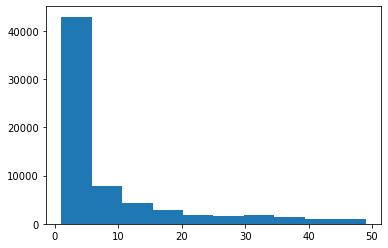

In [42]:
plt.hist(grid_popularity[grid_popularity < 50])

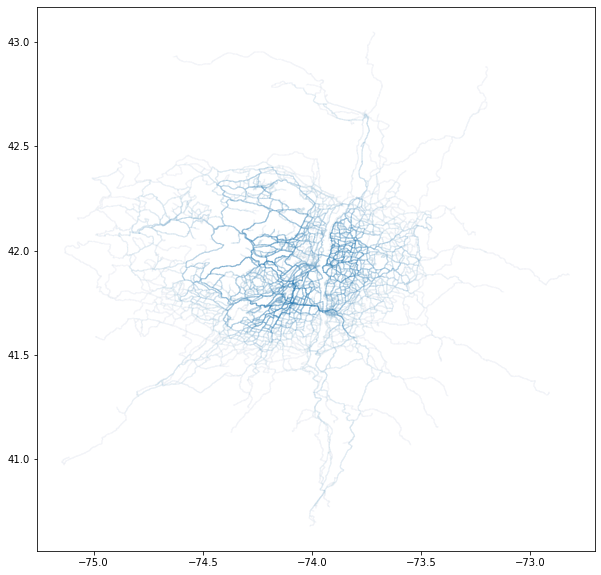

In [40]:
plt.figure(figsize=(10, 10))
grid_popularity
plt.scatter(grid_pts_500.lon, grid_pts_500.lat, grid_popularity/20000)

In [39]:
# Route popularity???
grid_popularity = rtes_at_grid_500.rte_ids.apply(len)
# grid_popularity[[4531792, 4531792]].sum()
rte_popularity = pd.DataFrame({'popularity': 0.}, index=gridpts_at_rte_500.index)
for rte_id, row in gridpts_at_rte_500.iterrows():
    rte_popularity.at[rte_id, 'popularity'] = grid_popularity[row[0].tolist()].mean()
rte_popularity

,popularity
rte_id,
7118848,41.944700
9805313,41.369625
54384283,4.760000
5702199,5.147287
52940048,7.036697
...,...
38476858,2.294118
53673900,5.445596
49303084,4.426966


In [ ]:
plt.hist(rte_popularity.popularity)

## Detour-worthiness

In [ ]:
gridpts_at_rte_500 = pd.read_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_500.feather')
gridpts_at_rte_500.set_index('rte_id', inplace=True)

grid_pts_500 = pd.read_feather(config.MODEL_PATH + 'grid_points_500.feather')
grid_pts_500.set_index('grid_id', inplace=True)

rtes_at_grid_500 = pd.read_feather(config.MODEL_PATH + 'rtes_at_grid_500.feather')
rtes_at_grid_500.set_index('grid_id', inplace=True)

In [ ]:
rte_endpts = pd.DataFrame({'lat_start': 0., 'lon_start': 0., 
                           'lat_end': 0., 'lon_end': 0., 'tot_dist': 0},
                          index=gridpts_at_rte_500.index)

for i, rte_id in enumerate(rte_endpts.index.tolist()):
    if not i % 500: print(i)
    a = pd.read_feather(config.CLEAN_TRIPS_PATH + '{}.feather'.format(rte_id))
    rte_endpts.loc[rte_id] = [a.iloc[0].lat, a.iloc[0].lon, 
                              a.iloc[-1].lat, a.iloc[-1].lon, a.dist.sum()]

In [ ]:
grid_detours = collections.defaultdict(list)
grid_detours_prop = collections.defaultdict(list)
deg_to_mile = mapping.degrees_to_miles_ish(1)

n = 0
for rte_id, row in rte_endpts.iterrows():
    if not n % 200: print(n)
    n += 1
    end_to_end = np.linalg.norm(
        np.array([row.lat_start, row.lon_start]) 
        - np.array([row.lat_end, row.lon_end]) 
    ) * deg_to_mile
    for grid_id in gridpts_at_rte_500.loc[rte_id, 'grid_ids']:
        start_to_mid = np.linalg.norm(
            np.array([row.lat_start, row.lon_start]) 
            - np.array([grid_pts_500.at[grid_id, 'lat'],
                        grid_pts_500.at[grid_id, 'lon']])
        ) * deg_to_mile
        end_to_mid = np.linalg.norm(
            np.array([row.lat_end, row.lon_end]) 
            - np.array([grid_pts_500.at[grid_id, 'lat'],
                        grid_pts_500.at[grid_id, 'lon']])
        ) * deg_to_mile
        
        d = start_to_mid + end_to_mid - end_to_end
        grid_detours[grid_id] += [d]
        grid_detours_prop[grid_id] += [d / row.tot_dist]
    
    
gd = pd.DataFrame({'detours': '', 'detours_prop': ''},
                 index=grid_pts_500.index)
n = 0
for k in grid_detours.keys():
    if not n % 1000: print(n)
    n += 1
    gd.at[k, 'detours'] = grid_detours[k]
    gd.at[k, 'detours_prop'] = grid_detours_prop[k]
    
gd.reset_index().to_feather(config.PROCESSED_DATA_PATH + 'detours.feather')

In [ ]:
gd.reset_index().to_feather(config.PROCESSED_DATA_PATH + 'detours.feather')

In [ ]:
grid_pts_500.head()

In [ ]:
gl = gd.detours_prop.apply(len)
dp = gd.detours_prop.apply(np.mean)
dp[gl < 10] = 0
gd['detour_score'] = dp
plt.hist(dp)

In [ ]:
gd.head()

In [ ]:
# grid_detours_df = a.detours.apply(np.mean)
plt.figure(figsize=(10, 10))
gd['lon'] = grid_pts_500.lon
gd['lat'] = grid_pts_500.lat
gd['dp'] = dp
plt.plot(grid_pts_500.lon, grid_pts_500.lat, 'k.', markersize=0.05)
# sns.scatterplot(x='lon', y='lat', hue='dp', data=gd, palette='magma_r')


counts = dp[gl > 10]
interval = 0.025
detour_bins = list(np.arange(0.1, 0.4, interval))
colours = sns.color_palette('magma_r', len(detour_bins) + 1)
for i, ll in enumerate(detour_bins):
    b = counts[(ll < counts) & (counts < ll + interval)].index.tolist()
    plt.plot(grid_pts_500.loc[b].lon, grid_pts_500.loc[b].lat, 
             '.', color=colours[i], markersize=0.1 + i * 0.1)
    
b = counts[max(detour_bins) < counts].index.tolist()
plt.plot(grid_pts_500.loc[b].lon, grid_pts_500.loc[b].lat, 
         '.', color=colours[i + 1], markersize=0.1 + (i + 1) * 0.1)
# plt.scatter(, grid_detours_df/50000
plt.xlim([-74.6, -73.6])
plt.ylim([41.5, 42.4])
plt.gca().set_aspect('equal')

In [ ]:
gd.loc[row[0].tolist()]

In [ ]:
rte_detourscore = pd.DataFrame({'detour_score': 0.}, index=gridpts_at_rte_500.index)
for rte_id, row in gridpts_at_rte_500.iterrows():
    rte_detourscore.at[rte_id, 'detour_score'] = gd.loc[row[0].tolist()].detour_score.mean()
rte_detourscore

a = pd.merge(rte_detourscore.reset_index(), rte_popularity.reset_index(), on='rte_id')
a.head()
a.to_feather(config.PROCESSED_DATA_PATH + 'rte_pop_detour.feather')

In [ ]:
plt.hist(a.popularity)

In [ ]:
# rte_detourscore.shape
a.head()

In [ ]:
a = pd.merge(rte_detourscore.reset_index(), rte_popularity.reset_index(), on='rte_id')
a.head()
a.to_feather(config.PROCESSED_DATA_PATH + 'rte_pop_detour.feather')
a.describe()

In [ ]:
g = gd.reset_index().rename(columns={'rte_id':'grid_id'})
a = pd.merge(grid_pts_1000.reset_index(), g, how='left')

In [ ]:
# plt.hist(grid_detours_df * deg_to_mile)
# grid_detours_df *= deg_to_mile
b = grid_detours_df[grid_detours_df > 50].index.tolist()
plt.plot(grid_pts_1000.loc[b].lon, grid_pts_1000.loc[b].lat, 'k.')

In [ ]:
a = a[['grid_id', 'detours']].set_index('grid_id')
a.head()

In [ ]:
# gd.detours.apply(len).describe()
gd.tail()

In [ ]:
a = grid_detours.keys()
a

In [ ]:
grid_detours[4531792]